In [ ]:
pip install cvxpy openpyxl ecos scs

In [1]:
import re, numpy as np, pandas as pd, cvxpy as cp
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

### Liabilities

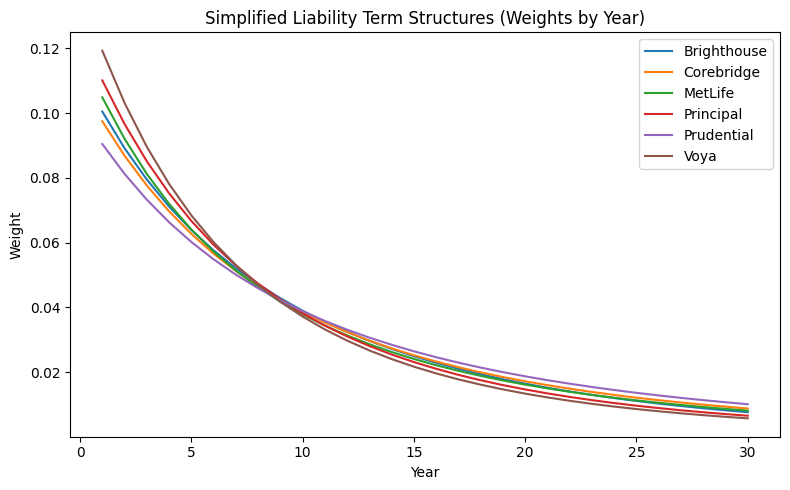

'Liability_Profiles.xlsx'

In [2]:
T = 30
years = np.arange(1, T + 1)

# --- Bucket duration presets (years) ---
# Keep these simple and consistent; you can tweak per company if desired.
bucket_durations_default = {
    "Short": 4.0,
    "Medium": 8.0,
    "Long": 20.0,
}

# --- Company-specific mixes (weights must sum to 1) ---
# These are intentionally simple and aligned with each company's product mix:
# - More "retirement / VA hedging" -> more Medium, some Short
# - More "ULSG / payout annuities"  -> more Long
# - More "group benefits / stable value" -> more Short
company_bucket_weights = {
    "Brighthouse": {"Short": 0.10, "Medium": 0.45, "Long": 0.45},
    "Corebridge":  {"Short": 0.15, "Medium": 0.55, "Long": 0.30},
    "MetLife":     {"Short": 0.25, "Medium": 0.50, "Long": 0.25},
    "Principal":   {"Short": 0.20, "Medium": 0.60, "Long": 0.20},
    "Prudential":  {"Short": 0.15, "Medium": 0.45, "Long": 0.40},
    "Voya":        {"Short": 0.30, "Medium": 0.55, "Long": 0.15},
}

# Optionally tweak bucket durations per company (keep it very minor/simple)
company_bucket_durations = {
    "Brighthouse": {"Short": 3.0, "Medium": 7.0, "Long": 15.0},
    "Corebridge":  {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "MetLife":     {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "Principal":   {"Short": 4.0, "Medium": 8.0, "Long": 18.0},
    "Prudential":  {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "Voya":        {"Short": 4.0, "Medium": 8.0, "Long": 18.0},
}

def make_liability_curve(weights, durations, years):
    """
    Exponential-decay blend:
        CF_t ∝ sum_b [ w_b * exp(-t / D_b) ]
    Then normalize so weights sum to 1 across t=1..T.
    """
    curve = np.zeros_like(years, dtype=float)
    for b, w in weights.items():
        D = durations[b]
        curve += w * np.exp(-years / D)
    curve /= curve.sum()
    return curve

# Build curves and summary metrics
records = []
summary_rows = []
curves = {}

for company, wts in company_bucket_weights.items():
    durs = company_bucket_durations.get(company, bucket_durations_default)
    curve = make_liability_curve(wts, durs, years)
    curves[company] = curve

    # Simple "Macaulay-like" stats on the discrete weights (no discount curve applied here)
    duration_years = float(np.sum(curve * years))
    convexity = float(np.sum(curve * (years ** 2)))  # rough proxy (unscaled)

    # Liquidity metrics (share of total CF in first 1y / 5y)
    liq_1y = float(curve[0])  # year 1 weight
    liq_5y = float(np.sum(curve[:5]))

    # Save per-year records
    for t, wt in zip(years, curve):
        records.append({"Company": company, "Year": t, "Liability_Weight": wt})

    summary_rows.append({
        "Company": company,
        "Avg_Duration_yrs": duration_years,
        "Convexity_proxy": convexity,
        "Share_1Y": liq_1y,
        "Share_5Y": liq_5y,
        "Short_wt": wts["Short"],
        "Medium_wt": wts["Medium"],
        "Long_wt": wts["Long"],
        "Short_D": durs["Short"],
        "Medium_D": durs["Medium"],
        "Long_D": durs["Long"],
    })

df_curves = pd.DataFrame(records)
df_summary = pd.DataFrame(summary_rows).set_index("Company")

# Plot all six curves on one chart (each line is the per-year weight)
plt.figure(figsize=(8, 5))
for company, curve in curves.items():
    plt.plot(years, curve, label=company)
plt.title("Simplified Liability Term Structures (Weights by Year)")
plt.xlabel("Year")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()

# Build an Excel workbook with:
# - Assumptions sheet (bucket weights & durations)
# - LiabilityCurves sheet (per company, per year weights)
# - Summary sheet (duration, convexity proxy, liquidity shares)
assumptions_rows = []
for company in company_bucket_weights:
    row = {"Company": company}
    row.update({f"BucketWeight_{k}": v for k, v in company_bucket_weights[company].items()})
    row.update({f"BucketDur_{k}": v for k, v in company_bucket_durations[company].items()})
    assumptions_rows.append(row)
df_assumptions = pd.DataFrame(assumptions_rows).set_index("Company")

excel_path = "Liability_Profiles.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    df_assumptions.to_excel(writer, sheet_name="Assumptions")
    df_curves.pivot(index="Year", columns="Company", values="Liability_Weight").to_excel(writer, sheet_name="LiabilityCurves")
    df_summary.to_excel(writer, sheet_name="Summary")

excel_path

In [3]:
EXCEL_PATH = "final_inputs.xlsx"
SHEET_NAME = 0
RISK_FREE = 0.04
N_FRONTIER_POINTS = 200
DUR_TARGET = 6.0
DUR_TOL = 1.0
LIQUID_MIN = None
W_MIN_DEFAULT = 0.00
W_MAX_DEFAULT = 0.10
LIABILITY_BOOK_PATH = "Liability_Profiles.xlsx"
LIABILITY_COMPANY = None
KRD_TOL = 0.10
KEY_BUCKETS = {"KR1": (0,3), "KR5": (3,7), "KR10": (7,12), "KR20": (12,25), "KR30": (25,40)}

In [ ]:
def nearest_psd(A, eps=1e-10):
    B = 0.5 * (A + A.T)
    vals, vecs = np.linalg.eigh(B)
    vals_clipped = np.maximum(vals, eps)
    return vecs @ np.diag(vals_clipped) @ vecs.T

def rating_to_numeric_fixed(rating):
    """Returns rating score only for fixed income assets, None for others"""
    scale = {
        "AAA": 1, "AA+": 2, "AA": 3, "AA-": 4,
        "A+": 5, "A": 6, "A-": 7,
        "BBB+": 8, "BBB": 9, "BBB-": 10,
        "BB+": 11, "BB": 12, "BB-": 13,
        "B+": 14, "B": 15, "B-": 16,
        "CCC": 17, "CC": 18, "C": 19
    }
    rating_str = str(rating).strip()
    if rating_str in scale:
        return scale[rating_str]
    else:
        return None  # No rating = not fixed income

def load_inputs(path, sheet=0):
    df = pd.read_excel(path, sheet_name=sheet).dropna(how="all")
    assets = df.iloc[:, 0].astype(str).values
    ratings = df.iloc[:, 1].astype(str).values
    mu = df.iloc[:, 2].astype(float).values
    sigma_ref = df.iloc[:, 3].astype(float).values
    duration = df.iloc[:, 4].astype(float).fillna(0.0).values
    n = len(assets)
    cov = df.iloc[:, 5:5+n].astype(float).values
    if cov.shape != (n, n):
        raise ValueError(f"Covariance must be {n}x{n}, got {cov.shape}")
    S = nearest_psd(0.5 * (cov + cov.T))
    return assets, ratings, mu, sigma_ref, duration, S

# ------------------------------------------------
# OPTIMIZATION FUNCTIONS
# ------------------------------------------------
def add_us_constraints_fixed(constraints, w, assets, ratings, rating_scores, duration=None, company_liability_duration=None):
    # --- Credit quality minimum (only for fixed income assets) ---
    min_avg_rating_score = 5  # A+ or better
    has_rating_mask = np.array([score is not None for score in rating_scores])
    
    if has_rating_mask.any():  # Only apply if we have rated assets
        # Create weighted average constraint only for rated assets
        rated_weights = w[has_rating_mask]
        rated_scores = np.array([score for score in rating_scores if score is not None])
        total_rated_weight = cp.sum(rated_weights)
        
        # Weighted average: only among rated assets
        # If rated assets have weight >= 0.01, apply credit quality constraint
        constraints += [rated_scores @ rated_weights <= min_avg_rating_score * total_rated_weight]

    # --- Rating-based masks (only for rated assets) ---
    rating_map = dict(zip(assets, ratings))
    is_bbb = np.array([rating_map[a] == "BBB" for a in assets])
    is_below_ig = np.array([rating_map[a] in {"BB", "BB-", "B+", "B", "B-", "CCC"} for a in assets])

    constraints += [cp.sum(w[is_bbb]) <= 0.15]
    constraints += [cp.sum(w[is_below_ig]) <= 0.05]

    # --- Structured products ---
    is_structured = np.array([
        any(k in a for k in ["Residential Mortgage-Backed", "Commercial Mortgage-Backed", "Asset-Backed"])
        for a in assets
    ])
    constraints += [cp.sum(w[is_structured]) <= 0.20]

    # --- Strategic assets ---
    is_equity = np.array(["Private Equity" in a for a in assets])
    is_hy_loans = np.array(["Leveraged Loans" in a for a in assets])
    is_emd_ig = np.array(["ex-US" in a for a in assets])
    is_real_estate = np.array(["Real Estate" in a for a in assets])
    is_cml = np.array([
        "Residential Mortgage Whole Loans" in a or "Commercial Mortgage Whole Loans" in a for a in assets
    ])
    is_direct_lending = np.array(["Direct Lending" in a for a in assets])
    is_alternatives = np.array(["Alternatives" in a or "Special Situation" in a for a in assets])
    is_strategic = is_equity | is_hy_loans | is_emd_ig | is_real_estate | is_cml | is_direct_lending | is_alternatives

    constraints += [cp.sum(w[is_equity]) <= 0.05]
    constraints += [cp.sum(w[is_hy_loans]) <= 0.05]
    constraints += [cp.sum(w[is_emd_ig]) <= 0.10]
    constraints += [cp.sum(w[is_real_estate]) <= 0.05]
    constraints += [cp.sum(w[is_cml]) <= 0.20]
    constraints += [cp.sum(w[is_direct_lending]) <= 0.20]
    constraints += [cp.sum(w[is_alternatives]) <= 0.05]
    constraints += [cp.sum(w[is_strategic]) <= 0.35]

    # --- Asset-Liability Duration Mismatch Constraint ---
    if duration is not None and company_liability_duration is not None:
        portfolio_duration = duration @ w
        constraints += [portfolio_duration >= company_liability_duration - 1.0]
        constraints += [portfolio_duration <= company_liability_duration + 1.0]

    return constraints

# Updated optimization functions
def solve_min_variance_fixed(mu, S, duration, target_mu, wmin, wmax, liq_mask, assets, ratings, rating_scores, company_liability_duration=None):
    n = len(mu)
    w = cp.Variable(n)
    constraints = [cp.sum(w) == 1, w >= wmin, w <= wmax, mu @ w >= target_mu]
    constraints = add_us_constraints_fixed(constraints, w, assets, ratings, rating_scores, duration, company_liability_duration)
    if DUR_TARGET is not None and DUR_TOL is not None:
        constraints += [duration @ w >= DUR_TARGET - DUR_TOL, duration @ w <= DUR_TARGET + DUR_TOL]
    if LIQUID_MIN is not None:
        constraints += [cp.sum(w[liq_mask]) >= LIQUID_MIN]
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, S)), constraints)
    try:
        prob.solve(solver=cp.SCS, verbose=False)
    except:
        try:
            prob.solve(solver=cp.ECOS, verbose=False)
        except:
            return None
    if prob.status not in ("optimal", "optimal_inaccurate"):
        return None
    return w.value, float(w.value @ S @ w.value), float(mu @ w.value)

def solve_max_sharpe_fixed(mu, S, duration, wmin, wmax, liq_mask, assets, ratings, rating_scores, rf=0.0, company_liability_duration=None):
    best = None
    sigmas = np.linspace(0.01, 0.20, 30)
    n = len(mu)
    for sig in sigmas:
        w = cp.Variable(n)
        constraints = [cp.sum(w) == 1, w >= wmin, w <= wmax, cp.quad_form(w, S) <= sig**2]
        constraints = add_us_constraints_fixed(constraints, w, assets, ratings, rating_scores, duration, company_liability_duration)
        if DUR_TARGET is not None and DUR_TOL is not None:
            constraints += [duration @ w >= DUR_TARGET - DUR_TOL, duration @ w <= DUR_TARGET + DUR_TOL]
        if LIQUID_MIN is not None:
            constraints += [cp.sum(w[liq_mask]) >= LIQUID_MIN]
        prob = cp.Problem(cp.Maximize(mu @ w - rf), constraints)
        try:
            prob.solve(solver=cp.SCS, verbose=False)
        except:
            try:
                prob.solve(solver=cp.ECOS, verbose=False)
            except:
                continue
        if prob.status in ("optimal", "optimal_inaccurate"):
            wv = w.value
            var = float(wv @ S @ wv)
            ret = float(mu @ wv)
            sh = (ret - rf) / np.sqrt(var) if var > 0 else -np.inf
            if best is None or sh > best[3]:
                best = (wv, var, ret, sh)
    return best

In [ ]:
def main_fixed(show_plots=True, export_csv=True):
    if not Path(EXCEL_PATH).exists():
        print(f"Error: {EXCEL_PATH} not found")
        return

    assets, ratings, mu, sigma_ref, duration, Sigma = load_inputs(EXCEL_PATH, SHEET_NAME)
    n = len(assets)
    wmin = np.full(n, W_MIN_DEFAULT)
    wmax = np.full(n, W_MAX_DEFAULT)
    
    # Use fixed rating function
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])
    
    # Show which assets have ratings
    has_rating = np.array([score is not None for score in rating_scores])
    print(f"Assets with ratings: {has_rating.sum()} out of {n}")
    print(f"Assets without ratings: {(~has_rating).sum()} out of {n}")
    
    liq_mask = np.array([
        bool(re.search(r"treasur|gov|agency|abs|mbs|muni|cash|t[- ]?bill|money", a, flags=re.I))
        for a in assets
    ])

    # --- Efficient Frontier (with more points) ---
    lo, hi = max(mu.min(), np.percentile(mu, 15)), mu.max()
    targets = np.linspace(lo, hi, N_FRONTIER_POINTS)
    frontier_pts, frontier_wts = [], []

    for t in targets:
        sol = solve_min_variance_fixed(mu, Sigma, duration, t, wmin, wmax,
                                      liq_mask, assets, ratings, rating_scores)
        if sol:
            w_opt, var, ret = sol
            frontier_pts.append((ret, np.sqrt(var)))
            frontier_wts.append(w_opt)

    # --- Max Sharpe ---
    ms = solve_max_sharpe_fixed(mu, Sigma, duration, wmin, wmax,
                               liq_mask, assets, ratings, rating_scores, rf=RISK_FREE)

    if ms:
        w_star, var_star, ret_star, sh_star = ms
        print(f"\nMax-Sharpe portfolio:"
              f"\n  Expected Return : {ret_star:.2%}"
              f"\n  Volatility      : {np.sqrt(var_star):.2%}"
              f"\n  Sharpe Ratio    : {sh_star:.2f}"
              f"\n  Duration (yrs)  : {duration @ w_star:.2f}"
              f"\n  Liquidity Share : {w_star[liq_mask].sum():.1%}\n")

        df_alloc = pd.DataFrame({"Asset": assets, "Weight": w_star})
        display(df_alloc.sort_values("Weight", ascending=False).style.format({"Weight": "{:.2%}"}))

    # --- Plot ---
    if show_plots and frontier_pts:
        rets, sigmas = zip(*frontier_pts)
        plt.figure(figsize=(8,5))
        plt.plot(sigmas, rets, "b-o", label="Efficient Frontier")
        if ms:
            plt.scatter([np.sqrt(var_star)], [ret_star], s=200, c="red", marker="*",
                        edgecolors="black", label=f"Max Sharpe ({sh_star:.2f})")
        plt.xlabel("Volatility"); plt.ylabel("Expected Return")
        plt.title("Efficient Frontier (US Insurer Constraints)")
        plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    # --- Export ---
    if export_csv and (frontier_pts or ms):
        rows = []
        for i, (ret, sigma) in enumerate(frontier_pts):
            row = {"type": "frontier", "idx": i, "mu": ret, "sigma": sigma}
            row.update({assets[j]: frontier_wts[i][j] for j in range(len(assets))})
            rows.append(row)
        if ms:
            row = {"type": "max_sharpe", "mu": ret_star, "sigma": np.sqrt(var_star), "sharpe": sh_star}
            row.update({assets[j]: w_star[j] for j in range(len(assets))})
            rows.append(row)
        pd.DataFrame(rows).to_excel("optimal_portfolios.xlsx", index=False)
        print("\nSaved results to optimal_portfolios.xlsx")

# Call the fixed main function
main_fixed(show_plots=True, export_csv=True)

### Brighthouse

In [12]:
def nearest_psd(A, eps=1e-10):
    B = 0.5 * (A + A.T)
    vals, vecs = np.linalg.eigh(B)
    vals_clipped = np.maximum(vals, eps)
    return vecs @ np.diag(vals_clipped) @ vecs.T

def rating_to_numeric_fixed(rating):
    """Returns rating score only for fixed income assets, None for others"""
    scale = {
        "AAA": 1, "AA+": 2, "AA": 3, "AA-": 4,
        "A+": 5, "A": 6, "A-": 7,
        "BBB+": 8, "BBB": 9, "BBB-": 10,
        "BB+": 11, "BB": 12, "BB-": 13,
        "B+": 14, "B": 15, "B-": 16,
        "CCC": 17, "CC": 18, "C": 19
    }
    rating_str = str(rating).strip()
    if rating_str in scale:
        return scale[rating_str]
    else:
        return None  # No rating = not fixed income

def load_inputs(path, sheet=0):
    df = pd.read_excel(path, sheet_name=sheet).dropna(how="all")
    assets = df.iloc[:, 0].astype(str).values
    ratings = df.iloc[:, 1].astype(str).values
    mu = df.iloc[:, 2].astype(float).values
    sigma_ref = df.iloc[:, 3].astype(float).values
    duration = df.iloc[:, 4].astype(float).fillna(0.0).values
    n = len(assets)
    cov = df.iloc[:, 5:5+n].astype(float).values
    if cov.shape != (n, n):
        raise ValueError(f"Covariance must be {n}x{n}, got {cov.shape}")
    S = nearest_psd(0.5 * (cov + cov.T))
    return assets, ratings, mu, sigma_ref, duration, S

def load_liability_profiles(path="Liability_Profiles.xlsx"):
    """Load liability duration profiles for all companies"""
    df_summary = pd.read_excel(path, sheet_name="Summary", index_col=0)
    return df_summary

def add_liability_duration_constraint(constraints, w, duration, company_liability_duration):
    """Add asset-liability duration mismatch constraint (±1 year)"""
    portfolio_duration = duration @ w
    liability_duration = company_liability_duration
    
    # Asset-liability mismatch should not exceed ±1 year
    constraints += [portfolio_duration >= liability_duration - 1.0]
    constraints += [portfolio_duration <= liability_duration + 1.0]
    
    return constraints

def solve_min_variance_corrected(mu, S, duration, target_mu, wmin, wmax, assets, ratings, rating_scores, company_liability_duration):
    """Min-variance optimization with ±1 year duration constraint"""
    n = len(mu)
    w = cp.Variable(n)
    w_equal = np.ones(n) / n
    lambda_conc = 0.005

    # MODIFIED OBJECTIVE: Minimize variance + concentration penalty
    objective = cp.quad_form(w, S) + lambda_conc * cp.sum_squares(w - w_equal)
    
    # Basic constraints
    constraints = [
        cp.sum(w) == 1,
        w >= wmin,
        w <= wmax,
        mu @ w >= target_mu,
        # CORRECTED: ±1 year liability duration constraint
        duration @ w >= company_liability_duration - 1.0,
        duration @ w <= company_liability_duration + 1.0
    ]
    
    # Credit quality constraint
    has_rating = np.array([score is not None for score in rating_scores])
    if has_rating.any():
        rated_weights = w[has_rating]
        rated_scores_array = np.array([score for score in rating_scores if score is not None])
        total_rated_weight = cp.sum(rated_weights)
        constraints += [rated_scores_array @ rated_weights <= 5 * total_rated_weight]
    
    # Rating limits
    rating_map = dict(zip(assets, ratings))
    is_bbb = np.array([rating_map[a] == "BBB" for a in assets])
    is_below_ig = np.array([rating_map[a] in {"BB", "BB-", "B+", "B", "B-", "CCC"} for a in assets])
    
    constraints += [
        cp.sum(w[is_bbb]) <= 0.15,
        cp.sum(w[is_below_ig]) <= 0.05
    ]
    
    is_equity = np.array(["Private Equity" in a for a in assets])
    is_hy_loans = np.array(["Leveraged Loans" in a for a in assets])
    is_emd_ig = np.array(["ex-US" in a for a in assets])
    is_real_estate = np.array(["Real Estate" in a for a in assets])
    is_cml = np.array([
        "Residential Mortgage Whole Loans" in a or "Commercial Mortgage Whole Loans" in a for a in assets
    ])
    is_direct_lending = np.array(["Direct Lending" in a for a in assets])
    is_alternatives = np.array(["Alternatives" in a or "Special Situation" in a for a in assets])
    is_strategic = is_equity | is_hy_loans | is_emd_ig | is_real_estate | is_cml | is_direct_lending | is_alternatives

    constraints += [cp.sum(w[is_equity]) <= 0.05]
    constraints += [cp.sum(w[is_hy_loans]) <= 0.05]
    constraints += [cp.sum(w[is_emd_ig]) <= 0.10]
    constraints += [cp.sum(w[is_real_estate]) <= 0.05]
    constraints += [cp.sum(w[is_cml]) <= 0.20]
    constraints += [cp.sum(w[is_direct_lending]) <= 0.20]
    constraints += [cp.sum(w[is_alternatives]) <= 0.05]
    constraints += [cp.sum(w[is_strategic]) <= 0.35]
    
    # Solve
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status in ("optimal", "optimal_inaccurate"):
        return w.value, float(w.value @ S @ w.value), float(mu @ w.value)
    return None

In [ ]:
def optimize_brighthouse_corrected(show_plots=True):
    """Optimize Brighthouse portfolio with ±1 year duration matching"""
    
    # Load data
    assets, ratings, mu, sigma_ref, duration, Sigma = load_inputs(EXCEL_PATH, SHEET_NAME)
    liability_profiles = load_liability_profiles()
    company_liability_duration = liability_profiles.loc["Brighthouse", 'Avg_Duration_yrs']
    
    n = len(assets)
    wmin = np.full(n, W_MIN_DEFAULT)
    wmax = np.full(n, W_MAX_DEFAULT)
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])
    
    print(f"Brighthouse Optimization - Liability Duration: {company_liability_duration:.1f} years")
    print(f"Required duration range: {company_liability_duration-1:.1f} to {company_liability_duration+1:.1f} years")
    
    # Build efficient frontier
    lo, hi = max(mu.min(), np.percentile(mu, 15)), mu.max()
    targets = np.linspace(lo, hi, N_FRONTIER_POINTS)
    frontier_pts, frontier_wts = [], []

    for target_mu in targets:
        sol = solve_min_variance_corrected(mu, Sigma, duration, target_mu, wmin, wmax, 
                                          assets, ratings, rating_scores, company_liability_duration)
        if sol:
            w_opt, var, ret = sol
            frontier_pts.append((ret, np.sqrt(var)))
            frontier_wts.append(w_opt)

    # Find max Sharpe from frontier
    if frontier_pts:
        max_sharpe_idx = max(range(len(frontier_pts)), 
                            key=lambda i: (frontier_pts[i][0] - RISK_FREE) / frontier_pts[i][1])
        
        w_star = frontier_wts[max_sharpe_idx]
        ret_star, sigma_star = frontier_pts[max_sharpe_idx]
        sh_star = (ret_star - RISK_FREE) / sigma_star
        portfolio_duration = duration @ w_star
        
        print(f"\n✓ Results:")
        print(f"  Return: {ret_star:.2%}, Volatility: {sigma_star:.2%}, Sharpe: {sh_star:.2f}")
        print(f"  Portfolio Duration: {portfolio_duration:.1f} years")
        print(f"  Duration Mismatch: {portfolio_duration - company_liability_duration:+.1f} years")
        
        # Show top holdings
        df_alloc = pd.DataFrame({"Asset": assets, "Weight": w_star, "Rating": ratings})
        df_alloc = df_alloc.sort_values("Weight", ascending=False)
        print(f"\nTop 10 Holdings:")
        display(df_alloc.head(10).style.format({"Weight": "{:.2%}"}))
        
        # Plot
        if show_plots and frontier_pts:
            rets, sigmas = zip(*frontier_pts)
            plt.figure(figsize=(10, 6))
            plt.plot(sigmas, rets, 'b-o', label="Efficient Frontier", alpha=0.7)
            plt.scatter([sigma_star], [ret_star], s=300, c='red', marker='*',
                       edgecolors='black', label=f"Max Sharpe ({sh_star:.2f})")
            plt.xlabel("Volatility"); plt.ylabel("Expected Return")
            plt.title("Brighthouse Efficient Frontier (±1 year duration constraint)")
            plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
        
        return w_star, ret_star, sigma_star, sh_star
    else:
        print("✗ No feasible portfolios found with ±1 year duration constraint")
        print("   This means the asset universe cannot achieve the required duration range")
        return None

def solve_min_variance_corrected(mu, S, duration, target_mu, wmin, wmax, assets, ratings, rating_scores, company_liability_duration):
    """Min-variance optimization with ±1 year duration constraint"""
    n = len(mu)
    w = cp.Variable(n)
    w_equal = np.ones(n) / n
    lambda_conc = 0.005

    # MODIFIED OBJECTIVE: Minimize variance + concentration penalty
    objective = cp.quad_form(w, S) + lambda_conc * cp.sum_squares(w - w_equal)
    
    # Basic constraints
    constraints = [
        cp.sum(w) == 1,
        w >= wmin,
        w <= wmax,
        mu @ w >= target_mu,
        # CORRECTED: ±1 year liability duration constraint
        duration @ w >= company_liability_duration - 1.0,
        duration @ w <= company_liability_duration + 1.0
    ]
    
    # Credit quality constraint
    has_rating = np.array([score is not None for score in rating_scores])
    if has_rating.any():
        rated_weights = w[has_rating]
        rated_scores_array = np.array([score for score in rating_scores if score is not None])
        total_rated_weight = cp.sum(rated_weights)
        constraints += [rated_scores_array @ rated_weights <= 5 * total_rated_weight]
    
    # Rating limits
    rating_map = dict(zip(assets, ratings))
    is_bbb = np.array([rating_map[a] == "BBB" for a in assets])
    is_below_ig = np.array([rating_map[a] in {"BB", "BB-", "B+", "B", "B-", "CCC"} for a in assets])
    
    constraints += [
        cp.sum(w[is_bbb]) <= 0.15,
        cp.sum(w[is_below_ig]) <= 0.05
    ]
    
    is_equity = np.array(["Private Equity" in a for a in assets])
    is_hy_loans = np.array(["Leveraged Loans" in a for a in assets])
    is_emd_ig = np.array(["ex-US" in a for a in assets])
    is_real_estate = np.array(["Real Estate" in a for a in assets])
    is_cml = np.array([
        "Residential Mortgage Whole Loans" in a or "Commercial Mortgage Whole Loans" in a for a in assets
    ])
    is_direct_lending = np.array(["Direct Lending" in a for a in assets])
    is_alternatives = np.array(["Alternatives" in a or "Special Situation" in a for a in assets])
    is_strategic = is_equity | is_hy_loans | is_emd_ig | is_real_estate | is_cml | is_direct_lending | is_alternatives

    constraints += [cp.sum(w[is_equity]) <= 0.05]
    constraints += [cp.sum(w[is_hy_loans]) <= 0.05]
    constraints += [cp.sum(w[is_emd_ig]) <= 0.10]
    constraints += [cp.sum(w[is_real_estate]) <= 0.05]
    constraints += [cp.sum(w[is_cml]) <= 0.20]
    constraints += [cp.sum(w[is_direct_lending]) <= 0.20]
    constraints += [cp.sum(w[is_alternatives]) <= 0.05]
    constraints += [cp.sum(w[is_strategic]) <= 0.35]
    
    # Solve
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status in ("optimal", "optimal_inaccurate"):
        return w.value, float(w.value @ S @ w.value), float(mu @ w.value)
    return None

In [ ]:
# Run the fixed Brighthouse optimization
brighthouse_result = optimize_brighthouse_corrected(show_plots=True)

In [4]:
def optimize_brighthouse_full_output(show_plots=True, export_excel=True):
    """
    Optimize Brighthouse portfolio and output 6 portfolios (A-F) plus Max Sharpe
    with comprehensive metrics and allocations
    """
    
    # Load data
    assets, ratings, mu, sigma_ref, duration, Sigma = load_inputs(EXCEL_PATH, SHEET_NAME)
    liability_profiles = load_liability_profiles()
    company_liability_duration = liability_profiles.loc["Brighthouse", 'Avg_Duration_yrs']
    
    n = len(assets)
    wmin = np.full(n, W_MIN_DEFAULT)
    wmax = np.full(n, W_MAX_DEFAULT)
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])
    
    print(f"Brighthouse Optimization - Liability Duration: {company_liability_duration:.1f} years")
    print(f"Required duration range: {company_liability_duration-1:.1f} to {company_liability_duration+1:.1f} years\n")
    
    # Build efficient frontier
    lo, hi = max(mu.min(), np.percentile(mu, 15)), mu.max()
    targets = np.linspace(lo, hi, N_FRONTIER_POINTS)
    frontier_pts, frontier_wts = [], []

    for target_mu in targets:
        sol = solve_min_variance_corrected(mu, Sigma, duration, target_mu, wmin, wmax, 
                                          assets, ratings, rating_scores, company_liability_duration)
        if sol:
            w_opt, var, ret = sol
            frontier_pts.append((ret, np.sqrt(var)))
            frontier_wts.append(w_opt)

    if not frontier_pts:
        print("✗ No feasible portfolios found")
        return None
    
    # FIXED: Select 6 portfolios by risk level, not index
    if len(frontier_pts) < 2:
        print("✗ Need at least 2 frontier points")
        return None
    
    # Sort frontier points by risk (volatility)
    frontier_data = [(ret, vol, i) for i, (ret, vol) in enumerate(frontier_pts)]
    frontier_data.sort(key=lambda x: x[1])  # Sort by volatility
    
    # Get min and max risk portfolios
    min_risk_idx = frontier_data[0][2]  # Index of minimum risk portfolio
    max_risk_idx = frontier_data[-1][2]  # Index of maximum risk portfolio
    
    min_vol = frontier_data[0][1]
    max_vol = frontier_data[-1][1]
    
    # Create 6 risk levels between min and max
    target_vols = np.linspace(min_vol, max_vol, 6)
    
    # Find closest portfolios to each target risk level
    selected_indices = []
    for target_vol in target_vols:
        closest_idx = min(range(len(frontier_data)), 
                         key=lambda i: abs(frontier_data[i][1] - target_vol))
        selected_indices.append(frontier_data[closest_idx][2])
    
    # Remove duplicates while preserving order
    unique_indices = []
    for idx in selected_indices:
        if idx not in unique_indices:
            unique_indices.append(idx)
    
    # If we don't have 6 unique portfolios, fill with remaining ones
    while len(unique_indices) < 6 and len(unique_indices) < len(frontier_pts):
        for ret, vol, idx in frontier_data:
            if idx not in unique_indices:
                unique_indices.append(idx)
                break
    
    # Find Max Sharpe (from all frontier points)
    max_sharpe_idx = max(range(len(frontier_pts)), 
                        key=lambda i: (frontier_pts[i][0] - RISK_FREE) / frontier_pts[i][1])
    
    # Collect all portfolios (A-F + Max Sharpe)
    portfolio_names = ['Port A', 'Port B', 'Port C', 'Port D', 'Port E', 'Port F', 'Max Sharpe']
    all_indices = unique_indices[:6] + [max_sharpe_idx]  # Take first 6 + Max Sharpe
    
    # Helper function to calculate weighted average rating
    def calc_avg_rating(weights, ratings_arr, rating_scores_arr):
        """Calculate weighted average rating for fixed income assets only"""
        has_rating = np.array([score is not None for score in rating_scores_arr])
        if not has_rating.any():
            return None
        
        fi_weights = weights[has_rating]
        fi_scores = np.array([score for score in rating_scores_arr if score is not None])
        
        total_fi_weight = fi_weights.sum()
        if total_fi_weight < 0.01:
            return None
        
        avg_score = (fi_weights @ fi_scores) / total_fi_weight
        
        # Convert score back to rating
        rating_map = {
            1: "AAA", 2: "AA+", 3: "AA", 4: "AA-", 5: "A+", 6: "A", 7: "A-",
            8: "BBB+", 9: "BBB", 10: "BBB-", 11: "BB+", 12: "BB", 13: "BB-",
            14: "B+", 15: "B", 16: "B-", 17: "CCC+"
        }
        
        rounded_score = round(avg_score)
        return rating_map.get(rounded_score, f"~{rounded_score}")
    
    # Build comprehensive results table
    results_data = {}
    
    for port_name, idx in zip(portfolio_names, all_indices):
        w = frontier_wts[idx]
        ret, vol = frontier_pts[idx]
        sharpe = (ret - RISK_FREE) / vol
        port_duration = duration @ w
        net_duration = port_duration - company_liability_duration
        avg_rating = calc_avg_rating(w, ratings, rating_scores)
        
        results_data[port_name] = {
            'Expected Return (%)': ret * 100,
            'Risk (%)': vol * 100,
            'Sharpe Ratio': sharpe,
            'Avg FI Credit Rating': avg_rating,
            'FI Duration (years)': port_duration,
            'Net Duration (years)': net_duration,
        }
        
        # Add individual asset weights
        for asset, weight in zip(assets, w):
            results_data[port_name][asset] = weight * 100  # Convert to percentage
    
    # Create DataFrame
    df_results = pd.DataFrame(results_data)
    
        # Display combined table
    print("="*120)
    print("PORTFOLIO COMPARISON TABLE")
    print("="*120)
    
    # Prepare combined table
    summary_metrics = ['Expected Return (%)', 'Risk (%)', 'Sharpe Ratio', 
                      'Avg FI Credit Rating', 'FI Duration (years)', 'Net Duration (years)']
    
    # Create combined display DataFrame
    df_combined = df_results.copy()
    
    # Apply formatting
    df_combined_display = df_combined.copy()
    
    # Format summary metrics (2 decimals for precision)
    for metric in summary_metrics:
        if metric == 'Avg FI Credit Rating':
            continue  # Keep as string
        else:
            for col in df_combined_display.columns:
                val = df_combined_display.loc[metric, col]
                if not pd.isna(val) and not isinstance(val, str):
                    formatted = f'{float(val):.2f}'
                    if formatted == '-0.00':
                        formatted = '0.00'
                    df_combined_display.loc[metric, col] = formatted
    
    # Format asset allocations (1 decimal, no % sign)
    asset_rows = [row for row in df_combined_display.index if row not in summary_metrics]
    for asset in asset_rows:
        for col in df_combined_display.columns:
            val = df_combined_display.loc[asset, col]
            if not pd.isna(val):
                formatted = f'{float(val):.1f}'
                if formatted == '-0.0':
                    formatted = '0.0'
                df_combined_display.loc[asset, col] = formatted
    
    # Filter assets to show only those with meaningful allocation (>0.5% in any portfolio)
    mask = df_results.loc[asset_rows].abs().max(axis=1) > 0.5
    meaningful_assets = [asset for asset in asset_rows if mask[asset]]
    
    # Create final display table
    final_rows = summary_metrics + meaningful_assets
    df_final = df_combined_display.loc[final_rows]
    
    # SIMPLE STYLING - no complex functions
    styled_table = df_final.style
    
    # Apply heatmap to asset allocation rows only (simple approach)
    if meaningful_assets:
        # Convert to numeric for heatmap
        asset_data = df_final.loc[meaningful_assets].apply(pd.to_numeric, errors='coerce')
        styled_table = styled_table.background_gradient(cmap='YlOrRd', axis=None, 
                                                      subset=pd.IndexSlice[meaningful_assets, :])
    
    display(styled_table)

    # Export to Excel
    if export_excel:
        output_file = "Brighthouse_Portfolio_Analysis.xlsx"
        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            df_results.to_excel(writer, sheet_name='Full_Results')
            df_final.to_excel(writer, sheet_name='Formatted_Display')
            
            # Create summary sheet
            summary_sheet = df_results.loc[summary_metrics]
            summary_sheet.to_excel(writer, sheet_name='Summary_Metrics')
        
        print(f"\n✓ Results exported to: {output_file}")
    
    # Plot efficient frontier
    if show_plots:
        rets, sigmas = zip(*frontier_pts)
        plt.figure(figsize=(12, 7))
        plt.plot(sigmas, rets, 'b-', alpha=0.3, label="Efficient Frontier")
        
        # Plot the 6 portfolios
                # Plot the 6 portfolios (FIXED VERSION)
                # Plot the 6 portfolios
        colors = ['green', 'blue', 'purple', 'orange', 'brown', 'pink']
        for i, (port_name, idx, color) in enumerate(zip(portfolio_names[:-1], unique_indices[:6], colors)):
            ret, vol = frontier_pts[idx]
            plt.scatter([vol], [ret], s=150, c=color, marker='o', 
                       edgecolors='black', label=port_name, zorder=5)        
        # Plot Max Sharpe
        ret_ms, vol_ms = frontier_pts[max_sharpe_idx]
        plt.scatter([vol_ms], [ret_ms], s=400, c='red', marker='*',
                   edgecolors='black', label='Max Sharpe', zorder=10)
        
        plt.xlabel("Volatility (%)", fontsize=12)
        plt.ylabel("Expected Return (%)", fontsize=12)
        plt.title("Brighthouse Efficient Frontier - Portfolio Selection", fontsize=14, fontweight='bold')
        plt.legend(loc='best', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return df_results

In [5]:
# Run the comprehensive analysis
results_df = optimize_brighthouse_full_output(show_plots=True, export_excel=False)

NameError: name 'load_inputs' is not defined

In [13]:
def optimize_brighthouse(show_plots=True, export_excel=False):
    
    # Load data
    assets, ratings, mu, sigma_ref, duration, Sigma = load_inputs(EXCEL_PATH, SHEET_NAME)
    liability_profiles = load_liability_profiles()
    company_liability_duration = liability_profiles.loc["Brighthouse", 'Avg_Duration_yrs']
    n = len(assets)
    wmin, wmax = np.full(n, W_MIN_DEFAULT), np.full(n, W_MAX_DEFAULT)
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])

    print(f"Brighthouse Optimization - Liability Duration: {company_liability_duration:.1f} years")
    print(f"Required duration range: {company_liability_duration-1:.1f} to {company_liability_duration+1:.1f} years\n")

    # Build efficient frontier
    targets = np.linspace(max(mu.min(), np.percentile(mu, 15)), mu.max(), N_FRONTIER_POINTS)
    frontier_pts, frontier_wts = [], []

    for target_mu in targets:
        sol = solve_min_variance_corrected(mu, Sigma, duration, target_mu, wmin, wmax, 
                                           assets, ratings, rating_scores, company_liability_duration)
        if sol:
            w_opt, var, ret = sol
            frontier_pts.append((ret, np.sqrt(var)))
            frontier_wts.append(w_opt)

    if not frontier_pts:
        print("✗ No feasible portfolios found with ±1 year duration constraint")
        return None

    # Select 6 risk-dispersed portfolios
    frontier_data = [(ret, vol, i) for i, (ret, vol) in enumerate(frontier_pts)]
    frontier_data.sort(key=lambda x: x[1])
    target_vols = np.linspace(frontier_data[0][1], frontier_data[-1][1], 6)
    selected_indices = []
    for target_vol in target_vols:
        idx = min(frontier_data, key=lambda x: abs(x[1] - target_vol))[2]
        if idx not in selected_indices:
            selected_indices.append(idx)
    while len(selected_indices) < 6 and len(selected_indices) < len(frontier_pts):
        for _, _, idx in frontier_data:
            if idx not in selected_indices:
                selected_indices.append(idx)
                break

    # Max Sharpe portfolio
    max_sharpe_idx = max(range(len(frontier_pts)), key=lambda i: (frontier_pts[i][0] - RISK_FREE) / frontier_pts[i][1])
    portfolio_names = ['Port A', 'Port B', 'Port C', 'Port D', 'Port E', 'Port F', 'Max Sharpe']
    all_indices = selected_indices[:6] + [max_sharpe_idx]

    def calc_avg_rating(weights, ratings_arr, rating_scores_arr):
        has_rating = np.array([score is not None for score in rating_scores_arr])
        if not has_rating.any(): return None
        fi_weights = weights[has_rating]
        fi_scores = np.array([score for score in rating_scores_arr if score is not None])
        total_weight = fi_weights.sum()
        if total_weight < 0.01: return None
        avg_score = (fi_weights @ fi_scores) / total_weight
        rating_map = {1: "AAA", 2: "AA+", 3: "AA", 4: "AA-", 5: "A+", 6: "A", 7: "A-", 8: "BBB+", 9: "BBB", 10: "BBB-",
                      11: "BB+", 12: "BB", 13: "BB-", 14: "B+", 15: "B", 16: "B-", 17: "CCC+"}
        return rating_map.get(round(avg_score), f"~{avg_score:.1f}")

    # Compile results
    results_data = {}
    for name, idx in zip(portfolio_names, all_indices):
        w = frontier_wts[idx]
        ret, vol = frontier_pts[idx]
        sharpe = (ret - RISK_FREE) / vol
        port_dur = duration @ w
        results_data[name] = {
            'Expected Return (%)': ret * 100,
            'Risk (%)': vol * 100,
            'Sharpe Ratio': sharpe,
            'Avg FI Credit Rating': calc_avg_rating(w, ratings, rating_scores),
            'FI Duration (years)': port_dur,
            'Net Duration (years)': port_dur - company_liability_duration
        }
        for a, weight in zip(assets, w):
            results_data[name][a] = weight * 100

    df_results = pd.DataFrame(results_data)

    # Format display
    summary = ['Expected Return (%)', 'Risk (%)', 'Sharpe Ratio', 'Avg FI Credit Rating',
               'FI Duration (years)', 'Net Duration (years)']
    df_display = df_results.copy()
    for metric in summary:
        if metric != 'Avg FI Credit Rating':
            for col in df_display.columns:
                val = df_display.loc[metric, col]
                df_display.loc[metric, col] = f"{float(val):.2f}" if not pd.isna(val) else val
    asset_rows = [row for row in df_display.index if row not in summary]
    for row in asset_rows:
        for col in df_display.columns:
            val = df_display.loc[row, col]
            df_display.loc[row, col] = f"{float(val):.1f}" if not pd.isna(val) else val
    mask = df_results.loc[asset_rows].abs().max(axis=1) > 0.5
    show_assets = [row for row in asset_rows if mask[row]]
    df_final = df_display.loc[summary + show_assets]
    styled_table = df_final.style
    if show_assets:
        styled_table = styled_table.background_gradient(cmap='YlOrRd', axis=None, subset=pd.IndexSlice[show_assets, :])

    print("="*120 + "\nPORTFOLIO COMPARISON TABLE\n" + "="*120)
    display(styled_table)

    if export_excel:
        with pd.ExcelWriter("Brighthouse_Portfolio_Analysis.xlsx") as writer:
            df_results.to_excel(writer, sheet_name='Full_Results')
            df_final.to_excel(writer, sheet_name='Formatted_Display')
            df_results.loc[summary].to_excel(writer, sheet_name='Summary_Metrics')
        print("\n✓ Results exported to: Brighthouse_Portfolio_Analysis.xlsx")

    if show_plots:
        rets, sigmas = zip(*frontier_pts)
        plt.figure(figsize=(12, 7))
        plt.plot(sigmas, rets, 'b-', alpha=0.3, label="Efficient Frontier")
        colors = ['green', 'blue', 'purple', 'orange', 'brown', 'pink']
        for name, idx, color in zip(portfolio_names[:-1], selected_indices[:6], colors):
            r, v = frontier_pts[idx]
            plt.scatter([v], [r], s=150, c=color, marker='o', edgecolors='black', label=name)
        r_ms, v_ms = frontier_pts[max_sharpe_idx]
        plt.scatter([v_ms], [r_ms], s=400, c='red', marker='*', edgecolors='black', label='Max Sharpe')
        plt.xlabel("Volatility (%)"); plt.ylabel("Expected Return (%)")
        plt.title("Brighthouse Efficient Frontier - Portfolio Selection", fontsize=14, fontweight='bold')
        plt.legend(loc='best'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    return df_results


Brighthouse Optimization - Liability Duration: 9.4 years
Required duration range: 8.4 to 10.4 years



c:\Users\gigan\AppData\Local\Programs\Python\Python313\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


PORTFOLIO COMPARISON TABLE


,Port A,Port B,Port C,Port D,Port E,Port F,Max Sharpe
Expected Return (%),4.37,4.42,4.44,4.45,4.46,4.46,4.46
Risk (%),3.37,3.40,3.44,3.46,3.51,3.55,3.55
Sharpe Ratio,0.11,0.12,0.13,0.13,0.13,0.13,0.13
Avg FI Credit Rating,AA-,A+,A+,A+,A+,A+,A+
FI Duration (years),8.38,8.38,8.38,8.38,8.38,8.38,8.38
Net Duration (years),-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
"US Treasuries, Long",10.0,10.0,10.0,10.0,10.0,10.0,10.0
US Taxable Munis,10.0,10.0,10.0,10.0,10.0,10.0,10.0
"Global ex-US Government, hedged",6.5,2.7,1.6,1.3,3.5,4.8,4.8
US Public Corporates IG AAA,4.3,1.8,2.0,2.0,2.2,-0.0,-0.0


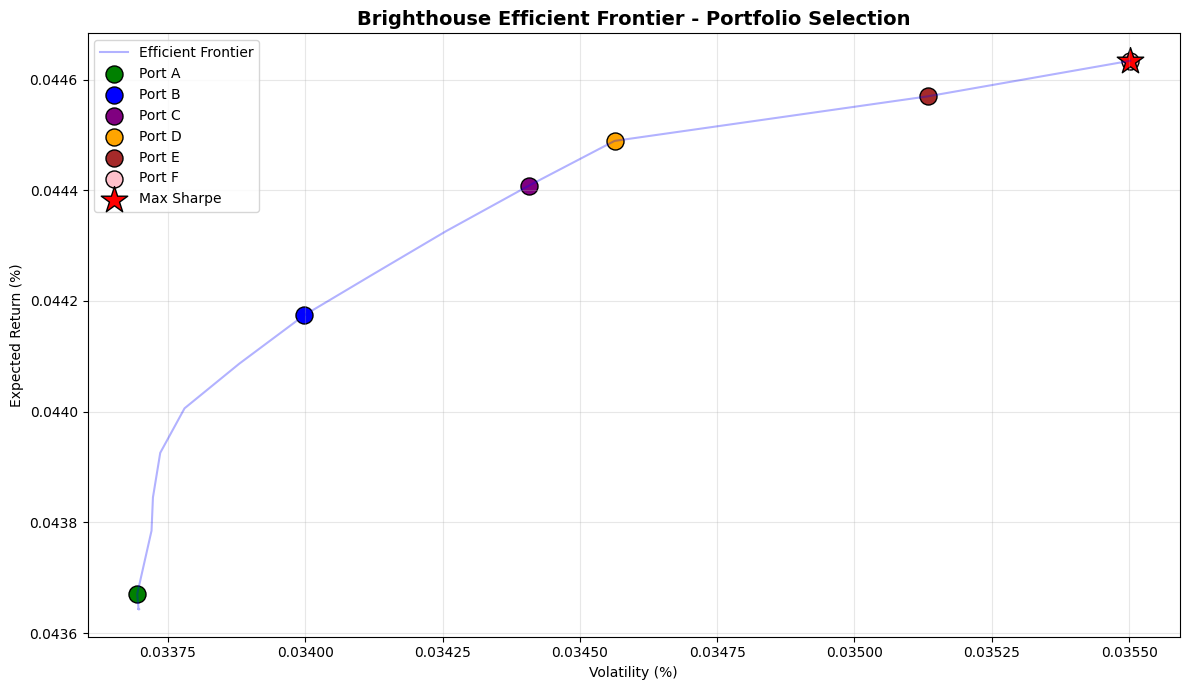

In [14]:
# Run the comprehensive analysis
results_df = optimize_brighthouse()